### Demo how to use OLR-based MJO index from Kiladis et al 2014 with the DREAM model). 
### Part 1/2.


* stephanie.leroux@ocean-next.fr
* Last update: 1/04/2019

#### Purpose: 
* This notebook shows how to read txt files of the Original OMI index proposed by Kiladis et al 2014 (see refs below), and make netcdf files from them to be used with the DREAM model

#### The Original OMI index from Kiladis et al 2014.
* Ref paper: https://doi.org/10.1175/MWR-D-13-00301.1
* Ref webpage: https://www.esrl.noaa.gov/psd/mjo/
* Summary: OOMI is a OLR-only-based index of the MJO that goes "smoothly" across seasons, and is based on 2-D space-EOFs (as opposed to the RMM index which is based on EOFs on latitudinal averages of OLR and  zonal wind at 200 and 850 hPa) .
* In more details, what is OOMI:
    - 30-96 day and easward-only filtered OLR (zonal mean + all eastward wavenumbers) over 1979-2018.
    - the first pair of EOF patterns is computed for EACH DAY of the calendar year (--> 366 pair in total), using the filtered OLR and using a sliding window of 121 days centered on each of the 366 calendar day.
* NOAA distribution: What NOAA provides is primarily the MJO index (i.e. PC1 and PC2 as a function of time, daily, from 1979-2018). What we are interested in is rather the EOF pairs for each calendar day (1->366). Those patterns are also available on the NOAA page (look for the "OMI EOF patterns" section down the page).
* Format of the EOF patterns txt files: NOAA provide one txt file per calendar day (366 in total) for EOF1 and one per day for EOF2. It's on a regular 2.5x2.5 grid (like NCEP2) but only in the tropics, from 20S to 20N
    
#### What this notebook does exactly:
* The OOMI text files contains only patterns on the 20S-20N tropical band so this notebook also takes care of expanding to a global grid (144x73) filled with zeroes out of the tropics. 
* This notebook (part 1/2) shows how to read the text files, assemble them, and convert to a T31 global grid: the resulting file contains 2 variables, EOF1 and EOF2, each of them containing 366 timesteps.
* Then i have made a second notebook ([part 2/2]( https://nbviewer.jupyter.org/github/dream-gcm/dream-tools/blob/master/demo_py_notebooks/SLX_customise_MJO_EOFs.ipynb)) that shows  how to convert the original regular lat-lon grid to a gaussian grid T42 (or T31) with the latitudes going from North to South in the end so that it can be easily convert to spectral space in the DREAM model and discuss the post-processing and choices to make on these EOF pairs before using them in DREAM.


In [1]:
# modules for dealing nicely with arrays and netcdf
import netCDF4 as nc
import pandas as pd
import os
import xarray as xr
import numpy as np


# modules for plot purposes
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Only if using jupyter notebook. Otherwise, comment out.
%matplotlib inline 

## Settings

In [29]:
# input/output dir
diri='/Users/leroux/DATA/DREAM_DATA/OMI_EOFpatterns/'

# name of the output file:
filo = 'OMI_EOFs_allyear.nc'

## Time coordinate for the 366 output pairs

* Create a time dimension for the 366 MJO EOF pairs to writew in netcdf 
* NOTE: we arbitrary choose year 1980 but it doesn't matter - what matters is that we have a daily calendar over one year, and this year is leap year.


In [36]:
units="hours since 1900-01-01 00:00:0.0"
timdim=pd.date_range(start='1980-01-01', end='1980-12-31', freq='24H')
timedimnum= nc.date2num(timdim.to_pydatetime(),units,calendar='standard')

In [11]:
timedimnum.size

366

## Read and concatenate EOFs for the 366 calendar julian days
NOAA provides one txt file per calendar day and per EOF. Below we process EOF1 then EOF2:

In [27]:
# loop to process EOF1 then EOF2:
for eofnam in ('eof1','eof2'):

        # this defines the name of the output variable in the output netcdf file
        if eofnam=='eof1':
            longname="EOF1 (OMI)"
        if eofnam=='eof2':
            longname="EOF2 (OMI)"

        # loop on each of the 366 calendar day
        for i in range(1,367):

            # text file name
            if i<10:
                fili='eof00'+str(i)+'.txt'
            else:
                if ((i>=10)&(i<100)):
                    fili='eof0'+str(i)+'.txt'
                else:
                    fili='eof'+str(i)+'.txt'   

            # open txt file    
            f_eoftxt = open(diri+eofnam+'/'+fili, 'r')

            # read all the data in that file at once:
            eoftxt=f_eoftxt.read()

            # then read the data line by line and convert to a np.array of floats
            eofflt = np.array(eoftxt.split()).astype(np.float)
            eofflt

            # add zeros at latitudes higher than 20N/S (so that the grid is global and of  1-d dim 144*73 as ncep2 reanalyse data)
            addzeros= np.zeros(28*144, dtype=float)
            globeof_1d = np.concatenate((addzeros,eofflt))
            globeof_1d = np.concatenate((globeof_1d,addzeros))

            # reshape in 2-d array
            globaleof_2d = np.reshape(globeof_1d, [73,144], order='C')

            # make it an xarray
            lon = np.arange(0,360,2.5)
            lat = np.arange(-90,92.5,2.5)
            XRglobaleof_2d = xr.DataArray(globaleof_2d, coords=[lat, lon], dims=['lat', 'lon'], name=eofnam)

            # concatenate in the allday_array
            if i==1:
                XRGLOB=XRglobaleof_2d
            else:
                XRGLOB=xr.concat((XRGLOB,XRglobaleof_2d),dim='time')
            del(XRglobaleof_2d)

        # add some attributes to the netcdf files.
        XRGLOB=XRGLOB.assign_coords(time=timdim)
        XRGLOB.attrs['long_name'] =  longname #"EOF1 (OMI)"
        XRGLOB_out=XRGLOB.assign_coords(time=timedimnum)
        XRGLOB_out.time.attrs['units']=units
        XRGLOB_out.time.attrs['calendar']='gregorian'
                
        # save final variable with different names for EOF1 and 2 so that we can use them in thje rest of the notebook
        if eofnam=='eof1':
            XRGLOB1_out = XRGLOB_out
        if eofnam=='eof2':
            XRGLOB2_out = XRGLOB_out

## Save the pairs of EOFs in a file (containing the EOF1,EOF2 pair for each of the 366 days)

In [28]:
XRGLOB1_out.to_netcdf(diri+filo,mode='w')
XRGLOB2_out.to_netcdf(diri+filo,mode='a')

## Now how to re-open and read this netcdf file:

### Read with xarray:

In [30]:
EOF1 = xr.open_dataset(diri+filo,decode_times=True)['eof1']
EOF2 = xr.open_dataset(diri+filo,decode_times=True)['eof2']

### Quick look at what's in the array:

In [40]:
EOF1

<xarray.DataArray 'eof1' (time: 366, lat: 73, lon: 144)>
[3847392 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 -77.5 -75.0 -72.5 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
Attributes:
    long_name:  EOF1 (OMI)

In [41]:
EOF2

<xarray.DataArray 'eof2' (time: 366, lat: 73, lon: 144)>
[3847392 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 -77.5 -75.0 -72.5 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
Attributes:
    long_name:  EOF2 (OMI)

### Quick plot of the pair of patterns for the first of april:

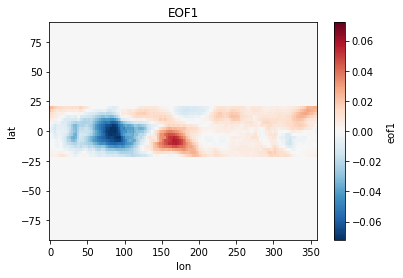

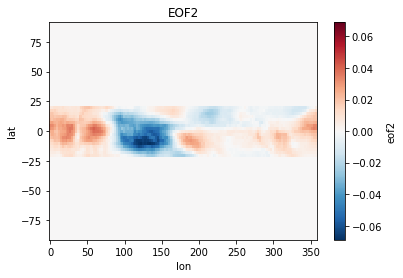

In [43]:
EOF1.sel(time='1980-04-01').plot()
plt.title('EOF1')
plt.show()

EOF2.sel(time='1980-04-01').plot()
plt.title('EOF2')
plt.show()

# Now go see the next notebook (part 2/2]( https://nbviewer.jupyter.org/github/dream-gcm/dream-tools/blob/master/demo_py_notebooks/SLX_customise_MJO_EOFs.ipynb)) to see how to play with those EOF pairs
link

## ___